In [ ]:
!pip install -U scikit-learn

In [ ]:
# Import dependencies
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from sklearn.datasets import load_wine
from sklearn import preprocessing

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from datetime import datetime
import calendar
import warnings
import os
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
base_dir = './drive/MyDrive/Colab Notebooks/smart-meters-in-london'

In [ ]:
# Read final dataset
df = pd.read_csv(os.path.join(base_dir, "energy_data.csv"))

In [ ]:
df.head()

,date,energy_sum,windBearing,windSpeed,cloudCover,pressure,visibility,humidity,icon,precipType,moonPhase,temp,holiday
0,2011-11-23,90.385000,229.0,2.04,0.36,1027.12,8.06,0.93,fog,rain,0.94,10.36,0
1,2011-11-24,213.412000,204.0,4.04,0.41,1027.22,10.64,0.89,partly-cloudy-night,rain,0.97,12.93,0
2,2011-11-25,303.993000,243.0,5.02,0.48,1024.47,12.38,0.79,partly-cloudy-day,rain,0.01,13.03,0
3,2011-11-26,420.976000,237.0,5.75,0.44,1025.80,13.07,0.81,wind,rain,0.05,12.96,0
4,2011-11-27,444.883001,256.0,5.48,0.42,1021.11,13.08,0.72,wind,rain,0.08,13.54,0


## Feature enginerering

In [ ]:
#df['wind'] = df['windBearing'] * df['windSpeed']

In [ ]:
#df = df.drop(['windBearing', 'windSpeed'], axis=1)

In [ ]:
# Dummy encode categorical feature precipType
le = preprocessing.LabelEncoder()
le.fit(df['precipType'])
df['precipType'] = le.transform(df['precipType'])

In [ ]:
# Dummy encode categorical feature icon
le = preprocessing.LabelEncoder()
le.fit(df['icon'])
df['icon'] = le.transform(df['icon'])

In [ ]:
# Save the dummy encoded dataset
df.to_csv(os.path.join(base_dir, "energy_data_train.csv"), sep=',', index=False, encoding='utf-8')

In [ ]:
# Training and test split (2/3 and 1/3 by default)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(df[['windBearing', 'windSpeed', 'cloudCover', 'pressure', 'visibility', 'humidity', 'icon', 'precipType', 'moonPhase', 'temp', 'holiday']], df.energy_sum, random_state=42)

# Regression

In [ ]:
# Missing value imputation (other strategies also availabe)
X_train.fillna(X_train.mean(), inplace=True)

In [ ]:
# Center and scale all X-train and X_test features
# Instantiate StandardScaler
scaler = StandardScaler()

# Fit it to the train data
scaler.fit(X_train)

# Use it to transform the train and test data
X_train = scaler.transform(X_train)

# Notice that the scaler is trained on the train data to avoid data leakage from the test set
X_test = scaler.transform(X_test)

## Random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Fit the classifier
rf_clr = RandomForestRegressor(n_estimators=2500, max_depth=19, random_state=42)
rf_clr.fit(X_train, y_train)

# Print the mean accuracy achieved by the classifier on the test set
rf_clr.score(X_test, y_test)

0.30765729639099926

## Feature selection

In [ ]:
# Feature importance
from sklearn.inspection import permutation_importance

feature_names = ['windBearing', 'windSpeed', 'cloudCover', 'pressure', 'visibility', 'humidity', 'icon', 'precipType', 'moonPhase', 'temp', 'holiday']

def feature_importance(clr, X, y, top_limit=None):

  # Retrieve the Bunch object after 50 repeats
  # n_repeats is the number of times that each feature was permuted to compute the final score
  bunch = permutation_importance(clr, X, y,
                                 n_repeats=50, random_state=42)

  # Average feature importance
  imp_means = bunch.importances_mean

  # List that contains the index of each feature in descending order of importance
  ordered_imp_means_args = np.argsort(imp_means)[::-1]

  # If no limit print all features
  if top_limit is None:
    top_limit = len(ordered_imp_means_args)

  # Print relevant information
  for i, _ in zip(ordered_imp_means_args, range(top_limit)):
    name = feature_names[i]
    imp_score = imp_means[i]
    imp_std = bunch.importances_std[i]
    print(f"Feature {name} with index {i} has an average importance score of {imp_score:.3f} +/- {imp_std:.3f}\n")

In [ ]:
# Feature importance for training data
feature_importance(rf_clr, X_train, y_train)

Feature temp with index 9 has an average importance score of 0.660 +/- 0.026

Feature pressure with index 3 has an average importance score of 0.486 +/- 0.032

Feature windBearing with index 0 has an average importance score of 0.177 +/- 0.009

Feature humidity with index 5 has an average importance score of 0.151 +/- 0.008

Feature cloudCover with index 2 has an average importance score of 0.115 +/- 0.008

Feature windSpeed with index 1 has an average importance score of 0.111 +/- 0.005

Feature visibility with index 4 has an average importance score of 0.110 +/- 0.006

Feature moonPhase with index 8 has an average importance score of 0.094 +/- 0.005

Feature icon with index 6 has an average importance score of 0.021 +/- 0.002

Feature holiday with index 10 has an average importance score of 0.001 +/- 0.000

Feature precipType with index 7 has an average importance score of 0.000 +/- 0.000



In [ ]:
# Feature importance for test data
feature_importance(rf_clr, X_test, y_test)

Feature pressure with index 3 has an average importance score of 0.462 +/- 0.073

Feature temp with index 9 has an average importance score of 0.335 +/- 0.048

Feature windBearing with index 0 has an average importance score of 0.045 +/- 0.018

Feature moonPhase with index 8 has an average importance score of 0.025 +/- 0.011

Feature cloudCover with index 2 has an average importance score of 0.023 +/- 0.012

Feature visibility with index 4 has an average importance score of 0.020 +/- 0.009

Feature humidity with index 5 has an average importance score of 0.018 +/- 0.018

Feature windSpeed with index 1 has an average importance score of 0.010 +/- 0.009

Feature icon with index 6 has an average importance score of 0.006 +/- 0.004

Feature precipType with index 7 has an average importance score of 0.000 +/- 0.000

Feature holiday with index 10 has an average importance score of 0.000 +/- 0.000



In [ ]:
# most 3 important features of both training and test data
print("On TRAIN split:\n")
feature_importance(rf_clr, X_train, y_train, top_limit=3)

print("\nOn TEST split:\n")
feature_importance(rf_clr, X_test, y_test, top_limit=3)

On TRAIN split:

Feature temp with index 9 has an average importance score of 0.660 +/- 0.026

Feature pressure with index 3 has an average importance score of 0.486 +/- 0.032

Feature windBearing with index 0 has an average importance score of 0.177 +/- 0.009


On TEST split:

Feature pressure with index 3 has an average importance score of 0.462 +/- 0.073

Feature temp with index 9 has an average importance score of 0.335 +/- 0.048

Feature windBearing with index 0 has an average importance score of 0.045 +/- 0.018



In [ ]:
# Train with the most important 3 features
X_train_top_features = X_train[:,[0, 3, 9]]
X_test_top_features = X_test[:,[0, 3, 9]]

# Re-train with only these features
rf_clf_top = RandomForestRegressor(n_estimators=500, max_depth=6, random_state=42).fit(X_train_top_features, y_train)

# Compute mean accuracy achieved
rf_clf_top.score(X_test_top_features, y_test)

0.28741363529331243

In [ ]:
# Train with the most important 4 features
X_train_top_features = X_train[:,[0, 2, 3, 9]]
X_test_top_features = X_test[:,[0, 2, 3, 9]]

# Re-train with only these features
rf_clf_top = RandomForestRegressor(n_estimators=500, max_depth=7, random_state=42).fit(X_train_top_features, y_train)

# Compute mean accuracy achieved
rf_clf_top.score(X_test_top_features, y_test)

0.30029625273044447

In [ ]:
# Train with the most important 5 features
X_train_top_features = X_train[:,[0, 2, 3, 8, 9]]
X_test_top_features = X_test[:,[0, 2, 3, 8, 9]]

# Re-train with only these features
rf_clf_top = RandomForestRegressor(n_estimators=400, max_depth=7, random_state=42).fit(X_train_top_features, y_train)

# Compute mean accuracy achieved
rf_clf_top.score(X_test_top_features, y_test)

0.32228447024307605

In [ ]:
# Train with the most important 6 features
X_train_top_features = X_train[:,[0, 2, 3, 5, 8, 9]]
X_test_top_features = X_test[:,[0, 2, 3, 5, 8, 9]]

# Re-train with only these features
rf_clf_top = RandomForestRegressor(n_estimators=700, max_depth=10, random_state=42).fit(X_train_top_features, y_train)

# Compute mean accuracy achieved
rf_clf_top.score(X_test_top_features, y_test)

0.3203274005799899

In [ ]:
# Train with the most important 6 features
X_train_top_features = X_train[:,[0, 2, 3, 4, 8, 9]]
X_test_top_features = X_test[:,[0, 2, 3, 4, 8, 9]]

# Re-train with only these features
rf_clf_top = RandomForestRegressor(n_estimators=650, max_depth=10, random_state=42).fit(X_train_top_features, y_train)

# Compute mean accuracy achieved
rf_clf_top.score(X_test_top_features, y_test)

0.3275184183366494

In terms of the training result with only temp, pressure, visibility, moonPhase, cloudCover and windBearing these 6 feature columns, generated the highest 32.75% accuracy on the validation data, and this dataset with less dimension, which means less computer resources required, it should be used insted of instead of the original dataset.

# Classification

In [ ]:
# Reading data
df = pd.read_csv(os.path.join(base_dir, "energy_data_train.csv"))

In [ ]:
# Labeling
def new_column(row):
    if row['energy_sum'] < 10000:
      return 0
    elif 10000 <= row['energy_sum'] < 20000:
      return 1
    elif 20000 <= row['energy_sum'] < 30000:
      return 2
    elif 30000 <= row['energy_sum'] < 40000:
      return 3
    elif 40000 <= row['energy_sum'] < 50000:
      return 4
    elif 50000 <= row['energy_sum'] < 60000:
      return 5
    elif 60000 <= row['energy_sum'] < 70000:
      return 6
    elif 70000 <= row['energy_sum'] < 80000:
      return 7  
    else:
      return 8

In [ ]:
df['energy_sum'] = df.apply(new_column, axis=1)

### Data spliting and feature engineering

In [ ]:
# Training and test split (2/3 and 1/3 by default)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(df[['windBearing', 'windSpeed', 'cloudCover', 'pressure', 'visibility', 'humidity', 'icon', 'precipType', 'moonPhase', 'temp', 'holiday']], df.energy_sum, random_state=42)

In [ ]:
# Missing value imputation (other strategies also availabe)
X_train.fillna(X_train.mean(), inplace=True)

In [ ]:
# Center and scale all X-train and X_test features
# Instantiate StandardScaler
scaler = StandardScaler()

# Fit it to the train data
scaler.fit(X_train)

# Use it to transform the train and test data
X_train = scaler.transform(X_train)

# Notice that the scaler is trained on the train data to avoid data leakage from the test set
X_test = scaler.transform(X_test)

### Resampling

In [ ]:
# Class imbalance analysis
from collections import Counter
counter = Counter(y_train)
for k,v in counter.items():
	per = v / len(y_train) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=0, n=66 (10.594%)
Class=5, n=116 (18.620%)
Class=2, n=32 (5.136%)
Class=7, n=27 (4.334%)
Class=4, n=151 (24.238%)
Class=1, n=56 (8.989%)
Class=3, n=69 (11.075%)
Class=8, n=2 (0.321%)
Class=6, n=104 (16.693%)


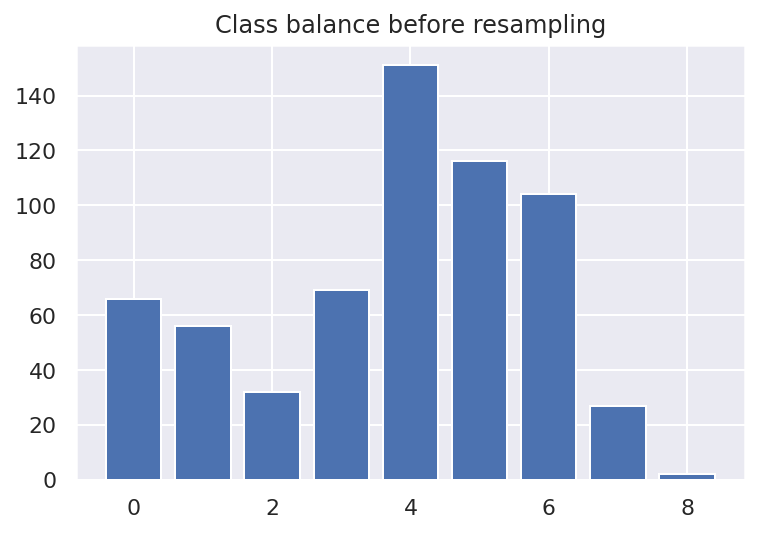

In [ ]:
# plot the classes distribution
plt.bar(counter.keys(), counter.values())
plt.title("Class balance before resampling")
plt.show()

Class=0, n=151 (11.111%)
Class=5, n=151 (11.111%)
Class=2, n=151 (11.111%)
Class=7, n=151 (11.111%)
Class=4, n=151 (11.111%)
Class=1, n=151 (11.111%)
Class=3, n=151 (11.111%)
Class=8, n=151 (11.111%)
Class=6, n=151 (11.111%)


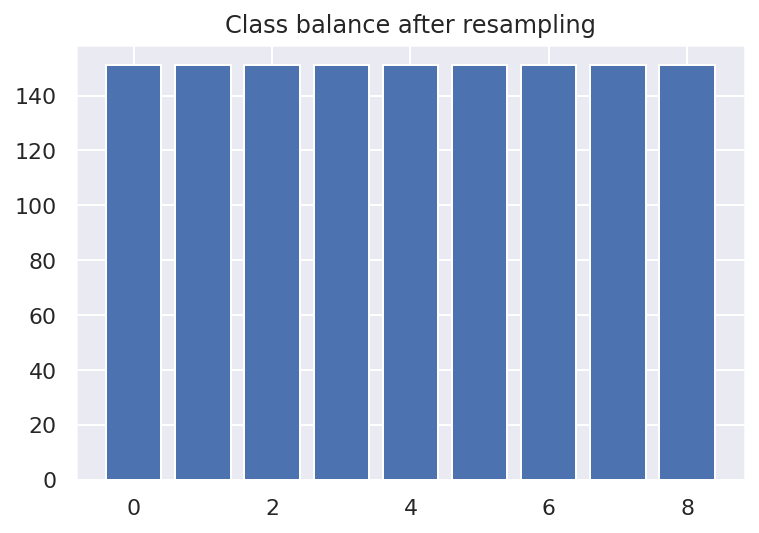

In [ ]:
# Resampling with SMOTE() from imblearn
# transform the dataset
oversample = SMOTE(kind='regular',k_neighbors=1)
X_train, y_train = oversample.fit_resample(X_train, y_train)
# summarize distribution
counter = Counter(y_train)
for k,v in counter.items():
	per = v / len(y_train) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.title("Class balance after resampling")
plt.show()

### Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Fit the classifier
rf_clf = RandomForestClassifier(n_estimators=800, max_depth=11, random_state=42).fit(X_train, y_train)

# Print the mean accuracy achieved by the classifier on the test set
rf_clf.score(X_test, y_test)

0.5528846153846154

In [ ]:
# Prediction on test data
y_pred = rf_clf.predict(X_test)

              precision    recall  f1-score   support

           0       0.53      0.72      0.61        25
           1       0.67      0.33      0.44        12
           2       0.12      0.25      0.17         4
           3       0.50      0.64      0.56        25
           4       0.74      0.59      0.65        58
           5       0.44      0.54      0.49        37
           6       0.58      0.42      0.48        36
           7       0.70      0.64      0.67        11
           8       0.00      0.00      0.00         0

    accuracy                           0.55       208
   macro avg       0.48      0.46      0.45       208
weighted avg       0.59      0.55      0.56       208



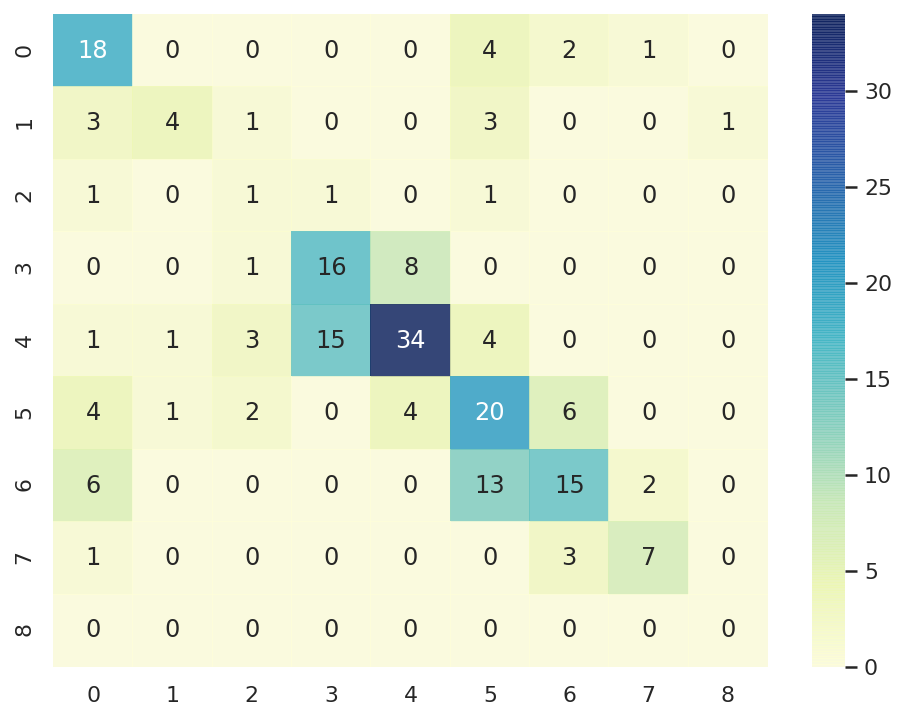

In [ ]:
# training report and confusion matrix
print(classification_report(y_test, y_pred))
plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

## Feature selection

In [ ]:
# Feature importance for training data
feature_importance(rf_clf, X_train, y_train)

Feature temp with index 9 has an average importance score of 0.451 +/- 0.010

Feature visibility with index 4 has an average importance score of 0.098 +/- 0.006

Feature humidity with index 5 has an average importance score of 0.088 +/- 0.006

Feature pressure with index 3 has an average importance score of 0.069 +/- 0.004

Feature windBearing with index 0 has an average importance score of 0.069 +/- 0.006

Feature windSpeed with index 1 has an average importance score of 0.040 +/- 0.004

Feature cloudCover with index 2 has an average importance score of 0.034 +/- 0.004

Feature moonPhase with index 8 has an average importance score of 0.025 +/- 0.002

Feature precipType with index 7 has an average importance score of 0.008 +/- 0.002

Feature icon with index 6 has an average importance score of 0.006 +/- 0.001

Feature holiday with index 10 has an average importance score of 0.002 +/- 0.000



In [ ]:
# Feature importance for test data
feature_importance(rf_clf, X_test, y_test)

Feature temp with index 9 has an average importance score of 0.311 +/- 0.026

Feature pressure with index 3 has an average importance score of 0.072 +/- 0.016

Feature visibility with index 4 has an average importance score of 0.053 +/- 0.022

Feature humidity with index 5 has an average importance score of 0.042 +/- 0.019

Feature icon with index 6 has an average importance score of 0.021 +/- 0.009

Feature windBearing with index 0 has an average importance score of 0.021 +/- 0.018

Feature cloudCover with index 2 has an average importance score of 0.012 +/- 0.018

Feature precipType with index 7 has an average importance score of 0.012 +/- 0.005

Feature windSpeed with index 1 has an average importance score of 0.008 +/- 0.016

Feature moonPhase with index 8 has an average importance score of 0.006 +/- 0.016

Feature holiday with index 10 has an average importance score of 0.000 +/- 0.001



In [ ]:
# Train with the most important 6 features
X_train_top_features = X_train[:,[0, 2, 3, 4, 5, 9]]
X_test_top_features = X_test[:,[0, 2, 3, 4, 5, 9]]

# Re-train with only these features
rf_clf_top = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42).fit(X_train_top_features, y_train)

# Compute mean accuracy achieved
rf_clf_top.score(X_test_top_features, y_test)

0.5480769230769231

In [ ]:
# Train with the most important 5 features
X_train_top_features = X_train[:,[0, 3, 4, 5, 9]]
X_test_top_features = X_test[:,[0, 3, 4, 5, 9]]

# Re-train with only these features
rf_clf_top = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42).fit(X_train_top_features, y_train)

# Compute mean accuracy achieved
rf_clf_top.score(X_test_top_features, y_test)

0.5480769230769231

In [ ]:
# Train with the most important 5 features
X_train_top_features = X_train[:,[0, 3, 4, 5, 9]]
X_test_top_features = X_test[:,[0, 3, 4, 5, 9]]

# Re-train with only these features
rf_clf_top = RandomForestClassifier(n_estimators=500, max_depth=9, random_state=42).fit(X_train_top_features, y_train)

# Compute mean accuracy achieved
rf_clf_top.score(X_test_top_features, y_test)

0.5576923076923077

In terms of the training result with only temp, pressure, visibility, humidity and windBearing these 5 feature columns, generated the highest 55.77% accuracy on the validation data, and this dataset with less dimension, which means less computer resources required, it should be used insted of instead of the original dataset.

## Feature selection with other methods

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier

# Select 4 new classifiers
clfs = {"Laso": Lasso(alpha=0.05), 
        "Ridge": Ridge(), 
        "Decision Tree": DecisionTreeClassifier(), 
        "Support Vector": SVC()}


# Compute feature importance on the test set given a classifier
def fit_compute_importance(clf):
  clf.fit(X_train, y_train)
  print(f"📏 Mean accuracy score on the test set: {clf.score(X_test, y_test)*100:.2f}%\n")
  print("🔝 Top 4 features when using the test set:\n")
  feature_importance(clf, X_test, y_test, top_limit=4)


# Print results
for name, clf in clfs.items():
  print("====="*20)
  print(f"➡️ {name} classifier\n")
  fit_compute_importance(clf)

➡️ Laso classifier

📏 Mean accuracy score on the test set: 1.00%

🔝 Top 4 features when using the test set:

Feature pressure with index 3 has an average importance score of 0.227 +/- 0.045

Feature windBearing with index 0 has an average importance score of 0.016 +/- 0.011

Feature temp with index 9 has an average importance score of 0.010 +/- 0.038

Feature icon with index 6 has an average importance score of 0.002 +/- 0.003

➡️ Ridge classifier

📏 Mean accuracy score on the test set: 0.58%

🔝 Top 4 features when using the test set:

Feature pressure with index 3 has an average importance score of 0.284 +/- 0.054

Feature temp with index 9 has an average importance score of 0.021 +/- 0.043

Feature humidity with index 5 has an average importance score of 0.018 +/- 0.011

Feature windBearing with index 0 has an average importance score of 0.013 +/- 0.010

➡️ Decision Tree classifier

📏 Mean accuracy score on the test set: 41.35%

🔝 Top 4 features when using the test set:

Feature temp

## DNN Model

In [ ]:
# Build the model
from tensorflow.keras import layers, models, optimizers
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import MaxPooling1D

model = Sequential()
model.add(Dense(16, input_shape=(11,), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
model.add(Dense(9, activation='softmax'))

  # Compile model
model.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
  

model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_152 (Dense)            (None, 16)                192       
_________________________________________________________________
dense_153 (Dense)            (None, 32)                544       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_154 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_155 (Dense)            (None, 9)                 153       
Total params: 1,417
Trainable params: 1,417
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# One hot encoding the labeling feature
from keras.utils.np_utils import to_categorical
y_cat = to_categorical(y_train)

In [ ]:
history = model.fit(X_train, y_cat, batch_size=16, epochs=100, verbose=True, validation_split=0.2)

Epoch 1/100
68/68 [==============================] - 1s 7ms/step - loss: 2.1730 - accuracy: 0.1343 - val_loss: 2.3302 - val_accuracy: 0.0000e+00
Epoch 2/100
68/68 [==============================] - 0s 5ms/step - loss: 2.0315 - accuracy: 0.1950 - val_loss: 2.5483 - val_accuracy: 0.0000e+00
Epoch 3/100
68/68 [==============================] - 0s 5ms/step - loss: 1.9033 - accuracy: 0.2300 - val_loss: 2.6619 - val_accuracy: 0.0000e+00
Epoch 4/100
68/68 [==============================] - 0s 5ms/step - loss: 1.7225 - accuracy: 0.3192 - val_loss: 2.6776 - val_accuracy: 0.0000e+00
Epoch 5/100
68/68 [==============================] - 0s 5ms/step - loss: 1.5716 - accuracy: 0.3726 - val_loss: 2.6914 - val_accuracy: 0.0000e+00
Epoch 6/100
68/68 [==============================] - 0s 5ms/step - loss: 1.4476 - accuracy: 0.3855 - val_loss: 2.5826 - val_accuracy: 0.0000e+00
Epoch 7/100
68/68 [==============================] - 0s 5ms/step - loss: 1.3914 - accuracy: 0.4149 - val_loss: 2.5681 - val_accura

In [ ]:
# Prediction on the test data
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

In [ ]:
# Model history plot
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

<Figure size 576x432 with 0 Axes>

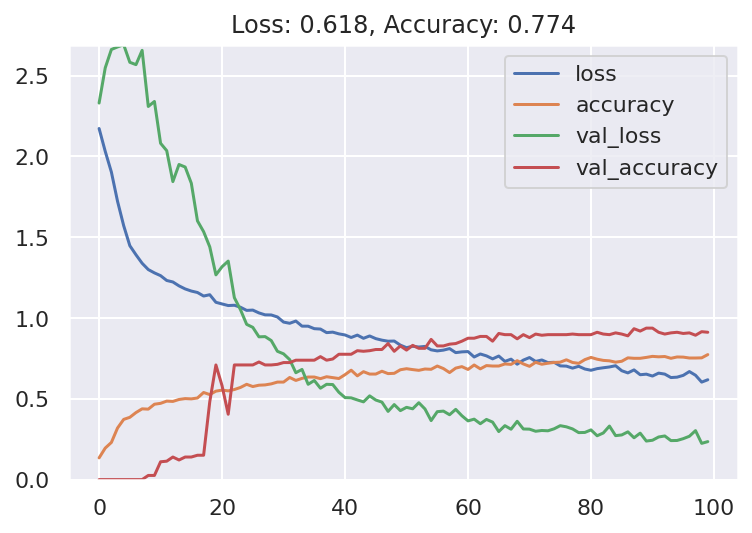

In [ ]:
# Plot the history figures
plot_loss_accuracy(history)

In [ ]:
# Confusion matrix
def plot_confusion_matrix(model, X, y):
    predict_x=model.predict(X) 
    y_pred = np.argmax(predict_x,axis=1)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

              precision    recall  f1-score   support

           0       0.47      0.72      0.57        25
           1       0.45      0.42      0.43        12
           2       0.00      0.00      0.00         4
           3       0.40      0.68      0.51        25
           4       0.68      0.40      0.50        58
           5       0.46      0.46      0.46        37
           6       0.64      0.39      0.48        36
           7       0.58      0.64      0.61        11

    accuracy                           0.49       208
   macro avg       0.46      0.46      0.45       208
weighted avg       0.54      0.49      0.49       208



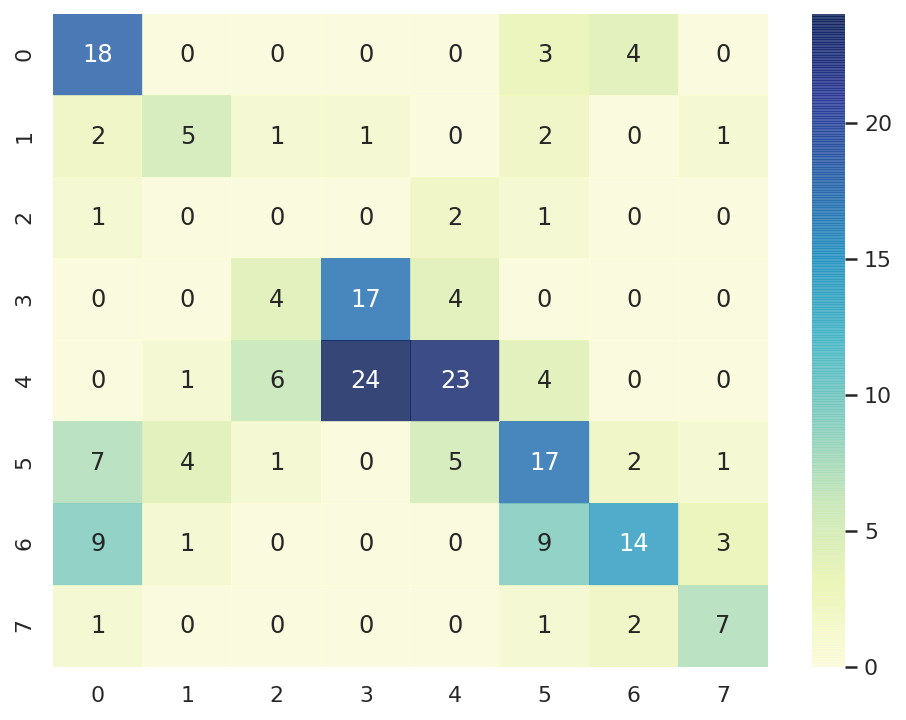

In [ ]:
# Plot the model performance report on the validation data and the confusion matrix
print(classification_report(y_test, classes_x))
plot_confusion_matrix(model, X_test, y_test)